# One Outlier (Section 4.1)

This file contains an experiment identifying a single influential point that can cause a sign flip, which AMIP fails to detect.

In [18]:
import numpy as np
import pandas as pd
import algorithms
import postprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from linear_regression import LinearRegression
import gurobipy as gp
from gurobipy import GRB

## Data Generation with intercept (i.e., an all-1's column).

In [4]:
np.random.seed(0)

# Generate Data
num_observations_pop_1 = 1
num_observations_pop_2 = 1000

# Generate the X values.
mean_pop_1 = np.array([1e6])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0]])
vars_pop_2 = [[1]]
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)

x = np.append(x1, x2, axis=0) 
x1_0 = [pt[0] for pt in x1]
x2_0 = [pt[0] for pt in x2]

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:1]
x2 = x[1:]

# Generating the Y values.
y1 = [1e6]

epsilon2 = np.random.normal(0, 1, num_observations_pop_2) # eps is the variance of the noise distribution.
slope = -1
intercept = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope*x2_0[i] + intercept + epsilon2[i]) # change here to add residual noise.

y = np.concatenate([y1, y2], axis=0)
# y

## Data Generation without intercept (i.e., an all-1's column).

In [19]:
np.random.seed(0)

# Generate Data
num_observations_pop_1 = 1
num_observations_pop_2 = 1000

# Generate the X values.
mean_pop_1 = np.array([1e6])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0]])
vars_pop_2 = [[1]]
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)

x = np.append(x1, x2, axis=0)
print(x)
x1 = x[:1]
x2 = x[1:]

# Add an intercept term.
# df = pd.DataFrame(x)
# df.insert(0, 'Ones', 1)
# arr = df.values
# x = arr

# Flatten x for ease of indexing.
x1_0 = x1.flatten()
x2_0 = x2.flatten()

# Generating the Y values.
y1 = [1e6]

epsilon2 = np.random.normal(0, 1, num_observations_pop_2) # eps is the variance of the noise distribution.
slope = -1
intercept = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope*x2_0[i] + intercept + epsilon2[i]) # change here to add residual noise.

y = np.concatenate([y1, y2], axis=0)
y

[[ 1.00000000e+06]
 [ 4.00157208e-01]
 [ 9.78737984e-01]
 ...
 [-1.14761094e+00]
 [-3.58114075e-01]
 [ 5.55962680e-01]]


array([ 1.00000000e+06,  4.92316679e-01, -1.40105281e+00, ...,
        5.70952564e-03, -9.52856295e-01, -2.08888373e+00])

## Model Fitting

Fit the data using OLS regression.

In [20]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
modified_lr_a = LinearRegression(x=x1.T, y=y1)
modified_lr_a.fit()
modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[0]}\n" # with intercept (lr.beta[1]), without intercept (lr.beta[0])
    f"Estimated beta1 pop A: {modified_lr_a.beta[0]}\n"
    f"Estimated beta1 pop B: {modified_lr.beta[0]}"
)

Estimated beta1 with full dataset: 0.9999999980204818
Estimated beta1 pop A: 1.0
Estimated beta1 pop B: -1.0334457351283335


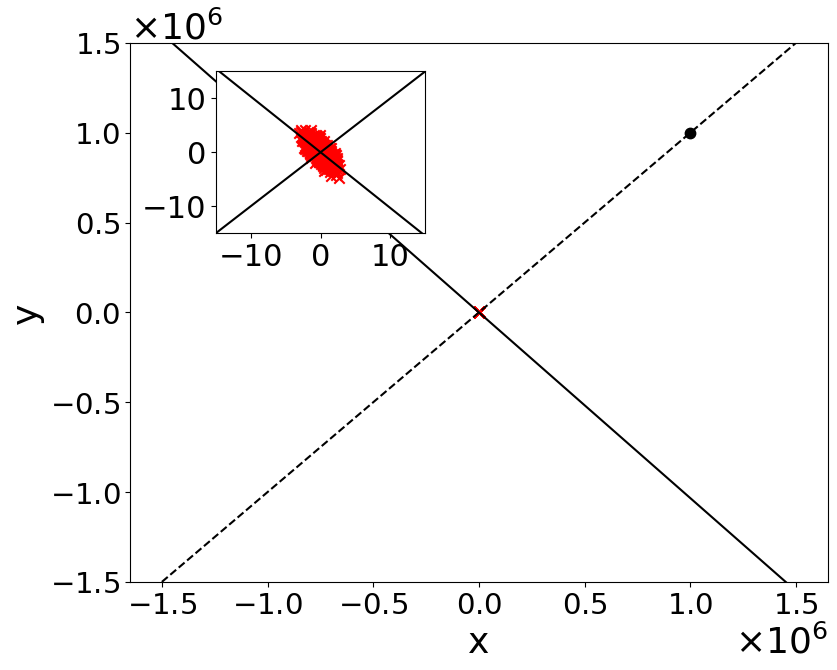

In [ ]:
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(9, 7))

x_values = np.linspace(-1.5e6, 1.5e6, 100)
y_values_full = lr.beta[0] * x_values
y_value_red_crosses = modified_lr.beta[0] * x_values

plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')
plt.scatter(x1_0, y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2_0, y2, marker='x', color='r', label='Pop. B', s=56)

plt.ylim(-1.5e6, 1.5e6)

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().yaxis.get_offset_text().set_fontsize(26)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().xaxis.get_offset_text().set_fontsize(26)

 # plt.legend(fontsize=22) # 16

# Create inset of the red crosses.
x_values_inset = np.linspace(-1.5e6, 1.5e6, 100)
y_values_full_inset = lr.beta[0] * x_values_inset
y_value_red_crosses_inset = modified_lr.beta[0] * x_values_inset

ax_inset = inset_axes(plt.gca(), width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.113, -0.040, 1.0, 1), bbox_transform=plt.gca().transAxes)
ax_inset.plot(x_values_inset, y_values_full_inset, color='black') 
ax_inset.plot(x_values_inset, y_value_red_crosses_inset, color='black')
ax_inset.scatter(x1_0, y1, marker='o', color='black', s=56)
ax_inset.scatter(x2_0, y2, marker='x', color='r', s=56)
ax_inset.set_xlim(-1.5e1, 1.5e1)  
ax_inset.set_ylim(-1.5e1, 1.5e1)
ax_inset.tick_params(axis='both', which='major', labelsize=22) # 12
ax_inset.tick_params(axis='both', which='minor', labelsize=22)
# set ticks to scientific notation
ax_inset.yaxis.get_offset_text().set_fontsize(12)
ax_inset.xaxis.get_offset_text().set_fontsize(12)


plt.show()

### Net Approx. Algorithm

In [8]:
n_sumwstar, wstar = algorithms.net_algorithm(x,y,1000)

Set parameter Username
Set parameter LicenseID to value 2617160
Academic license - for non-commercial use only - expires 2026-02-01


In [9]:
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indice of wstar that are non-one.
mis_inds = np.where(wstar != 1)[0]
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 0.9999999989939852


array([0])

### Gurobi [FH23]

In [ ]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

In [ ]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x[:, 0], y, intercept=True, time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

In [41]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([0])

### Gurobi (no warm start)

In [ ]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x[:, 0], y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1003 columns and 1 nonzeros
Model fingerprint: 0x9c46a6e1
Model has 2 quadratic constraints
Variable types: 2 continuous, 1001 integer (1001 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-06, 1e+12]
  QLMatrix range   [7e-04, 1e+12]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 4006 rows, 7009 columns, 16015 nonzeros
Presolved mode

In [34]:
integer_weights = np.array([w.X for w in weights])

In [35]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([0])

## Additive and Greedy algorithms.


#### Additive Algorithms.

In [12]:
outlier_df = postprocessing.compute_scores(x, y, lr, True)
outlier_df.head(5)

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1000000.000000,1000000.000000,0.001980,1.000000e+00,-1.979518e-09,-2.033445e+00,0,0,-1.979518e-09,-2.033445e+00
1,0.400157,0.492317,0.092159,1.601258e-13,-3.687828e-14,-3.687828e-14,256,256,-9.622614e-13,-9.622614e-13
2,0.978738,-1.401053,-2.379791,9.579280e-13,2.329192e-12,2.329192e-12,587,587,-7.346517e-13,-7.346517e-13
3,2.240893,-2.136179,-4.377072,5.021602e-12,9.808552e-12,9.808552e-12,94,94,-5.120421e-13,-5.120421e-13
4,1.867558,-1.639505,-3.507063,3.487773e-12,6.549643e-12,6.549643e-12,403,403,-4.398481e-13,-4.398481e-13


In [13]:
print(f'The AMIP approximation of the refit is {round(lr.beta[0] + sum(outlier_df["sorted_IF_scores"][:0]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is {round(lr.beta[0] + sum(outlier_df["sorted_1Exact_scores"][:1]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most 1 is {round((modified_lr.beta[0]), 4)}.')

The AMIP approximation of the refit is 1.0.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is -1.0334.
The true change induced by dropping the worst-case subset of size at most 1 is -1.0334.


#### Greedy Algorithms.

Greedy approximations for 1 data point is the same as the additive approximations.
